# Setting

In [60]:
import sentencepiece as spm
from torchtext.legacy.data import Field, TabularDataset, Iterator
import matplotlib.pyplot as plt

In [3]:
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

---
# SentencePiece Model

In [5]:
import sentencepiece as spm

In [ ]:
spm.SentencePieceTrainer.Train('--input=/content/gdrive/MyDrive/algorima/train_data --model_prefix=movie --vocab_size=16000 --model_type=bpe --max_sentence_length=9999')

---
# Load a sentence piece model and dataset

In [4]:
# Load sentence piece model

sp = spm.SentencePieceProcessor()
vocab_file = "./sp.model"
sp.load(vocab_file)

True

In [5]:
batch_size = 64
if torch.cuda.is_available():
    print('cuda')
    device = torch.device('cuda:0')
else:
    print('cpu')
    device = torch.device('cpu')

cuda


In [6]:
TEXT = Field(tokenize=sp.encode_as_ids,
             use_vocab=False,
             batch_first=True,
             fix_length=30,
             dtype=torch.float,
             pad_token=0,
             unk_token=16001)

LABEL = Field(sequential=False,
              use_vocab=False)

In [15]:
train_data = TabularDataset(
    path='./raw-data/train.tsv',
    format='tsv', fields=[('text', TEXT), ('label', LABEL)])

valid_data = TabularDataset(
    path='./raw-data/test.tsv',
    format='tsv', fields=[('text', TEXT), ('label', LABEL)])

- Loader

In [16]:
train_loader = Iterator(dataset=train_data, batch_size=batch_size, shuffle=True, device=device)
valid_loader = Iterator(dataset=valid_data, batch_size=batch_size, shuffle=True, device=device)

In [17]:
print(len(train_data))
print(len(valid_data))

285504
173861


---
# Network and functions

In [18]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(16001, 300)
        self.lstm1 = nn.LSTM(300, 128)
        self.lstm2 = nn.LSTM(128, 128)
        self.fc1 = nn.Linear(3840, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.embedding(x)
        x,_ = self.lstm1(x)
        x,_ = self.lstm2(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [40]:
def train(epochs, train_loader, valid_loader, model, optimizer, criterion, device):
    for epoch in range(1, epochs + 1):
        running_loss = 0.0

        for idx, data in enumerate(train_loader, 0):
            input = data.text.long().to(device)
            label = data.label.to(device)
            
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output.squeeze(1), label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if idx % 800 == 799:
                print('[%d, %d] loss: %.3f' %(epoch, idx + 1, running_loss / 800))
                running_loss = 0
                
        validation(model, valid_loader)
        model.train()

        if epoch % 2 == 0:  # Learning rate scheduling
            for g in optimizer.param_groups:
                g['lr'] *= 0.7
    
    return model

In [41]:
def validation(model, valid_loader):
    total = 0
    correct = 0
    with torch.no_grad():
        for idx, data in enumerate(valid_loader, 0):
            input = data.text.long().to(device)
            label = data.label.to(device)

            output = model(input)

            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        print('\tvalidation: {}%'.format((correct / total) * 100))

# Train

In [42]:
net = Network().to(device)
epochs = 10
lr = 0.3
optimizer = optim.SGD(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [43]:
net = train(epochs, train_loader, valid_loader, net, optimizer, criterion, device)

[1, 800] loss: 0.719
[1, 1600] loss: 0.246
[1, 2400] loss: 0.147
[1, 3200] loss: 0.124
[1, 4000] loss: 0.114
	validation: 96.07962682832837%
[2, 800] loss: 0.091
[2, 1600] loss: 0.088
[2, 2400] loss: 0.087
[2, 3200] loss: 0.081
[2, 4000] loss: 0.082
	validation: 94.7446523372119%
[3, 800] loss: 0.063
[3, 1600] loss: 0.062
[3, 2400] loss: 0.062
[3, 3200] loss: 0.064
[3, 4000] loss: 0.063
	validation: 96.8601353955171%
[4, 800] loss: 0.052
[4, 1600] loss: 0.055
[4, 2400] loss: 0.056
[4, 3200] loss: 0.058
[4, 4000] loss: 0.060
	validation: 97.06029529336654%
[5, 800] loss: 0.046
[5, 1600] loss: 0.046
[5, 2400] loss: 0.047
[5, 3200] loss: 0.046
[5, 4000] loss: 0.049
	validation: 97.04764150672088%
[6, 800] loss: 0.042
[6, 1600] loss: 0.040
[6, 2400] loss: 0.043
[6, 3200] loss: 0.043
[6, 4000] loss: 0.046
	validation: 97.19833660222822%
[7, 800] loss: 0.036
[7, 1600] loss: 0.036
[7, 2400] loss: 0.039
[7, 3200] loss: 0.036
[7, 4000] loss: 0.038
	validation: 97.43243165517282%
[8, 800] loss: 

# Save network

In [44]:
torch.save(net.state_dict(), './discriminator.model')

---
# Result

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

result = [[], []] # outputs, labels
total = 0
correct = 0
with torch.no_grad():
    for idx, data in enumerate(valid_loader, 0):
        input = data.text.long().to(device)
        label = data.label.to(device)

        output = net(input)

        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        result[0] += predicted.tolist()
        result[1] += label.tolist()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [52]:
outputs = result[0]
labels = result[1]

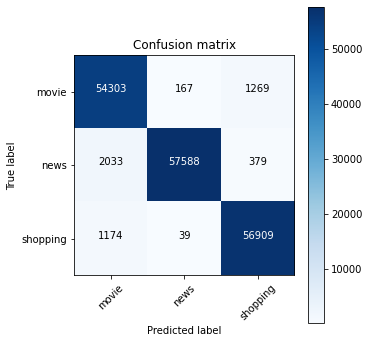

In [65]:
import numpy as np
import itertools
cm = confusion_matrix(labels, outputs)
classes = ['movie', 'news', 'shopping']

cmap=plt.cm.Blues
title='Confusion matrix'
normalize=False
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion_matrix.png")